# DGE using wilcoxon method

This notebook performs DGE using scanpy `rank_genes_groups` function and wilcoxon method.

**Dataset**: MIS-C dataset

**Type of cells**: HSPC

**DGE condition**: Different timepoints of disease status

**Inputs**: Filtered anndata object with HSPC cells only

**Outputs**: Volcano plots and csv file with DEGs and marker genes

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import os
from adjustText import adjust_text

In [3]:
input_dir = '/data/niecr/ramaiar/misc/results_seurat/anndata_obj'

In [4]:
output_dir = '/data/niecr/ramaiar/misc/results_seurat/DGE'

# 1.1 Load Data

In [5]:
rna_ad_path = os.path.join(input_dir, 'hspc_UNK_removed.h5ad')
rna_ad = sc.read_h5ad(rna_ad_path)
rna_ad

AnnData object with n_obs × n_vars = 19092 × 27424
    obs: 'og_barcode', 'batch_x', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'ribo_pct', 'mito_pct', 'doublet', 'doublet_score', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'orig.barcode', 'RNA_snn_res.2', 'seurat_clusters', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pANN_0.25_0.09_2745', 'DF.classifications_0.25_0.09_2745', 'DF.classifications_0.25_0.09_2627', 'pANN_0.25_0.09_623', 'DF.classifications_0.25_0.09_623', 'DF.classifications_0.25_0.09_808', 'pANN_0.25_0.09_701', 'DF.classifications_0.25_0.09_701', 'pANN_0.25_0.09_1124', 'DF.classifications_0.25_0.09_1124', 'pANN_0.25_0.09_1500', 'DF.classifications_0.25_0.09_1500', 'pANN_0.25_0.09_1478', 'DF.classifications_0.25_0.09_1478', '

# 1.2 Function to plot volcano plots

In [32]:
def plot_data(data, DGE_comparison, nrows, ncols, output_dir, out_name):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows))

    # Flatten axes into a 1D array for easier iteration
    if nrows == 1 and ncols == 1:
        axes = np.array([axes])
    
    axes = axes.flatten()

    # Iterate over each cohort and plot on respective subplot
    for i, groups in enumerate(DGE_comparison.keys()):
        reference = DGE_comparison[groups]['reference']
        group = DGE_comparison[groups]['group']
        
        if len(DGE_comparison.keys()) == 1:
            df = data.copy()
        else:
            df = data[group]
    
        # Filter data within reasonable logfoldchanges range
        df = df[(df['logfoldchanges'] >= -10) & (df['logfoldchanges'] <= 10)].copy()
    
        # Assign DGE categories based on logfoldchange and p-value
        df['DGE'] = 'NO'
        df.loc[(df['logfoldchanges'] > 0.6) & (df['pvals_adj'] < 0.05), 'DGE'] = 'UP'
        df.loc[(df['logfoldchanges'] < -0.6) & (df['pvals_adj'] < 0.05), 'DGE'] = 'DOWN'
    
        # Compute -log10(pvals)
        df['-log10(pvals_adj)'] = -np.log10(df['pvals_adj'].replace(0, np.nan))  # Handle zeros

        # Drop rows with infinite values (if any)
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
        # Separate into 'UP' and 'DOWN' DataFrames and select top 15 genes
        df['temp_score'] = df['-log10(pvals_adj)'] * df['logfoldchanges']
        df_up = df.sort_values(by='temp_score').head(15)
        df_down = df.sort_values(by='temp_score').tail(15)
        selected_genes = pd.concat([df_up, df_down])
    
        # Set up color palette for DGE
        color_palette = {'UP': 'red', 'DOWN': 'blue', 'NO': 'black'}
    
        # Plotting on current subplot
        sns.scatterplot(x='logfoldchanges', y='-log10(pvals_adj)', hue='DGE', data=df, palette=color_palette, legend=False, s=40, ax=axes[i])
    
        # Draw dotted lines
        axes[i].axvline(x=0.6, color='gray', linestyle='--')
        axes[i].axvline(x=-0.6, color='gray', linestyle='--')
        axes[i].axhline(y=-np.log10(0.05), color='gray', linestyle='--')
    
        # Annotation with gene names for top and bottom 10 genes
        texts = []
        for index, row in selected_genes.iterrows():
            texts.append(axes[i].text(row['logfoldchanges'], row['-log10(pvals_adj)'],
                                  row['names'], fontsize=8, ha='right', va='bottom'))  # Increased font size to 8
    
        # Adjust text positions to avoid overlap for current subplot
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5), ax=axes[i])
    
        # Customize plot
        axes[i].set_title(f'                 {reference} ', color='blue', loc='left',fontsize=12)
        axes[i].set_title('VS', color='black', loc='center',fontsize=12)
        axes[i].set_title(f'{group}              ', color='red', loc='right',fontsize=12)
        axes[i].set_xlabel('log2 fold change')
        axes[i].set_ylabel('-log10 p-value')
    
        # Remove grid and border
        axes[i].grid(False)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir,'hspc_MISC-recovered_all_cohorts_plots.png'))
    plt.show()

## 1.2. Pick the disease condition to compare DEGs 

In [33]:
condition = 'Disease.Status3' # Choose the condition or column you would like to group by

In [34]:
groups = rna_ad.obs[condition].dropna().unique().tolist()
groups

['Baseline_MIS-C',
 'D28_MIS-C',
 'MISC-recovered',
 'M6_POSSIBLE MIS-C',
 'nan',
 'Baseline_POSSIBLE MIS-C',
 'D28_POSSIBLE MIS-C',
 'Healthy_Healthy',
 'D28_COVID',
 'Baseline_COVID',
 'M6_COVID',
 'M12_COVID',
 'M12_POSSIBLE MIS-C']

In [35]:
# Keep only groups you would like to compare
groups.remove('nan')
groups

['Baseline_MIS-C',
 'D28_MIS-C',
 'MISC-recovered',
 'M6_POSSIBLE MIS-C',
 'Baseline_POSSIBLE MIS-C',
 'D28_POSSIBLE MIS-C',
 'Healthy_Healthy',
 'D28_COVID',
 'Baseline_COVID',
 'M6_COVID',
 'M12_COVID',
 'M12_POSSIBLE MIS-C']

# 2. Perform DGE on all groups

Compare DEGs between `MISC-recovered` group to every other group

In [36]:
rna_ad.uns['log1p'] = {'base': None}

In [37]:
reference = 'MISC-recovered' # Choose the reference group

In [38]:
# Recovered VS ALL
# corr_method='benjamini-hochberg'is required to get adjusted pvalue
sc.tl.rank_genes_groups(rna_ad,groupby=condition,groups=groups,reference=reference,
                        method='wilcoxon',corr_method='benjamini-hochberg',layer='log')

## 2.1. Generate CSV file with results

In [39]:
# Extracting results from differential expression analysis
result = rna_ad.uns['rank_genes_groups']

# Convert results to DataFrame for easier manipulation
groups = result['names'].dtype.names
dge_data = {}
for group in groups:
    dge_data[group] = pd.DataFrame({
        'names': result['names'][group],
        'logfoldchanges': result['logfoldchanges'][group],
        'pvals': result['pvals'][group],
        'pvals_adj': result['pvals_adj'][group],
        'scores': result['scores'][group]
    })

# Merge results into a single DataFrame
# Change the output csv file name
dge_df = pd.concat(dge_data, axis=1)
dge_df.to_csv(os.path.join(output_dir,'hspc_MISC-recovered_VS_all_wilcoxon.csv'))
dge_df

Baseline_MIS-C                                                          \
               names logfoldchanges          pvals      pvals_adj     scores   
0               AREG       3.369899  3.522859e-229  9.661087e-225  32.321209   
1              IRAK3       1.730419  4.756141e-176  6.521621e-172  28.288727   
2               LRBA       0.978891  8.425108e-175  7.701672e-171  28.187063   
3            TSC22D3       1.552597  3.342048e-142  2.110338e-138  25.388929   
4              SSBP2       0.844143  3.847611e-142  2.110338e-138  25.383389   
...              ...            ...            ...            ...        ...   
27419        ANKRD44      -0.600413   2.506542e-29   8.086989e-27 -11.243021   
27420       IFNG-AS1      -2.465737   2.133624e-29   6.965774e-27 -11.257229   
27421           XIST      -1.588778   1.491117e-36   6.195816e-34 -12.627407   
27422            B2M      -0.360939   8.069040e-43   4.610112e-40 -13.716667   
27423         MALAT1      -0.234029   3.561741e-51   2.959915e-48 -15.047936   

      D28_MIS-C                                                          ...  \
          names logfoldchanges          pvals      pvals_adj     scores  ...   
0       HNRNPA1       0.894623  9.835136e-121  2.697188e-116  23.364418  ...   
1        EEF1A1       0.511558  9.010087e-103   1.235463e-98  21.525370  ...   
2           VIM       0.935487   3.662586e-99   3.348092e-95  21.136639  ...   
3         EEF1G       0.763347   6.336131e-81   4.344051e-77  19.051899  ...   
4         GAPDH       0.771756   1.939164e-70   1.063593e-66  17.743380  ...   
...         ...            ...            ...            ...        ...  ...   
27419     PDE7A      -0.503474   2.471370e-24   7.530540e-22 -10.178581  ...   
27420      EML4      -0.672519   1.351514e-24   4.260221e-22 -10.237156  ...   
27421     MEF2C      -0.581767   1.278746e-26   4.383540e-24 -10.678829  ...   
27422     PRKCB      -0.515791   3.857853e-28   1.410637e-25 -10.999142  ...   
27423   ANKRD44      -0.550831   3.805159e-34   2.268537e-31 -12.183517  ...   

       M12_COVID                                                        \
           names logfoldchanges         pvals     pvals_adj     scores   
0          HLA-A       1.010613  3.502200e-45  4.802217e-41  14.105716   
1           XIST       1.252735  7.635037e-39  6.979442e-35  13.036009   
2          RACK1       0.745191  1.155502e-36  7.417280e-33  12.647460   
3         TMSB10       0.833642  8.591156e-36  3.365769e-32  12.488827   
4          HLA-B       0.633742  3.100906e-28  9.448806e-25  11.018822   
...          ...            ...           ...           ...        ...   
27419   MTRNR2L8      -1.286126  6.159418e-24  1.689159e-20 -10.089321   
27420  LINC00486      -3.132492  1.286020e-34  4.408477e-31 -12.271652   
27421      DDX3Y      -2.720807  3.772599e-36  1.724329e-32 -12.554139   
27422        HBB      -1.730932  1.352334e-36  7.417280e-33 -12.635094   
27423        UTY      -2.208717  2.300122e-55  6.307854e-51 -15.673381   

      M12_POSSIBLE MIS-C                                               \
                   names logfoldchanges          pvals      pvals_adj   
0             AC105402.3       4.681375  4.058207e-223  1.112923e-218   
1                 MALAT1       0.448344   3.061215e-88   4.197537e-84   
2               MTRNR2L8       1.179447   9.130509e-55   6.259877e-51   
3                  H3F3B       0.761488   4.793594e-42   2.629190e-38   
4                  HLA-A       0.870683   1.606705e-38   7.343712e-35   
...                  ...            ...            ...            ...   
27419              MBNL1      -0.361757   3.284895e-21   2.905967e-18   
27420          LINC00486      -2.387986   1.311335e-23   1.438482e-20   
27421               XIST      -4.057091   2.886875e-35   7.916966e-32   
27422           ARHGAP15      -0.546251   5.987519e-38   2.052522e-34   
27423          MTRNR2L12      -1.179989   4.815946e-78   4.402417e-74   

           

# 2.2. Generate volcano plots for groups of interest

In [40]:
# dictionary of groups of interest
DGE_comparison = { 1: {'reference': 'MISC-recovered', 'group': 'Baseline_MIS-C'},
                 2: {'reference': 'MISC-recovered', 'group': 'D28_MIS-C'},
                 3: {'reference': 'MISC-recovered', 'group': 'Baseline_COVID'},
                 4: {'reference': 'MISC-recovered', 'group': 'D28_COVID'},
                 5: {'reference': 'MISC-recovered', 'group': 'M6_COVID'},
                 6: {'reference': 'MISC-recovered', 'group': 'M12_COVID'}}

In [41]:
# Change these based on the number of plots
nrows = 2
ncols = 3

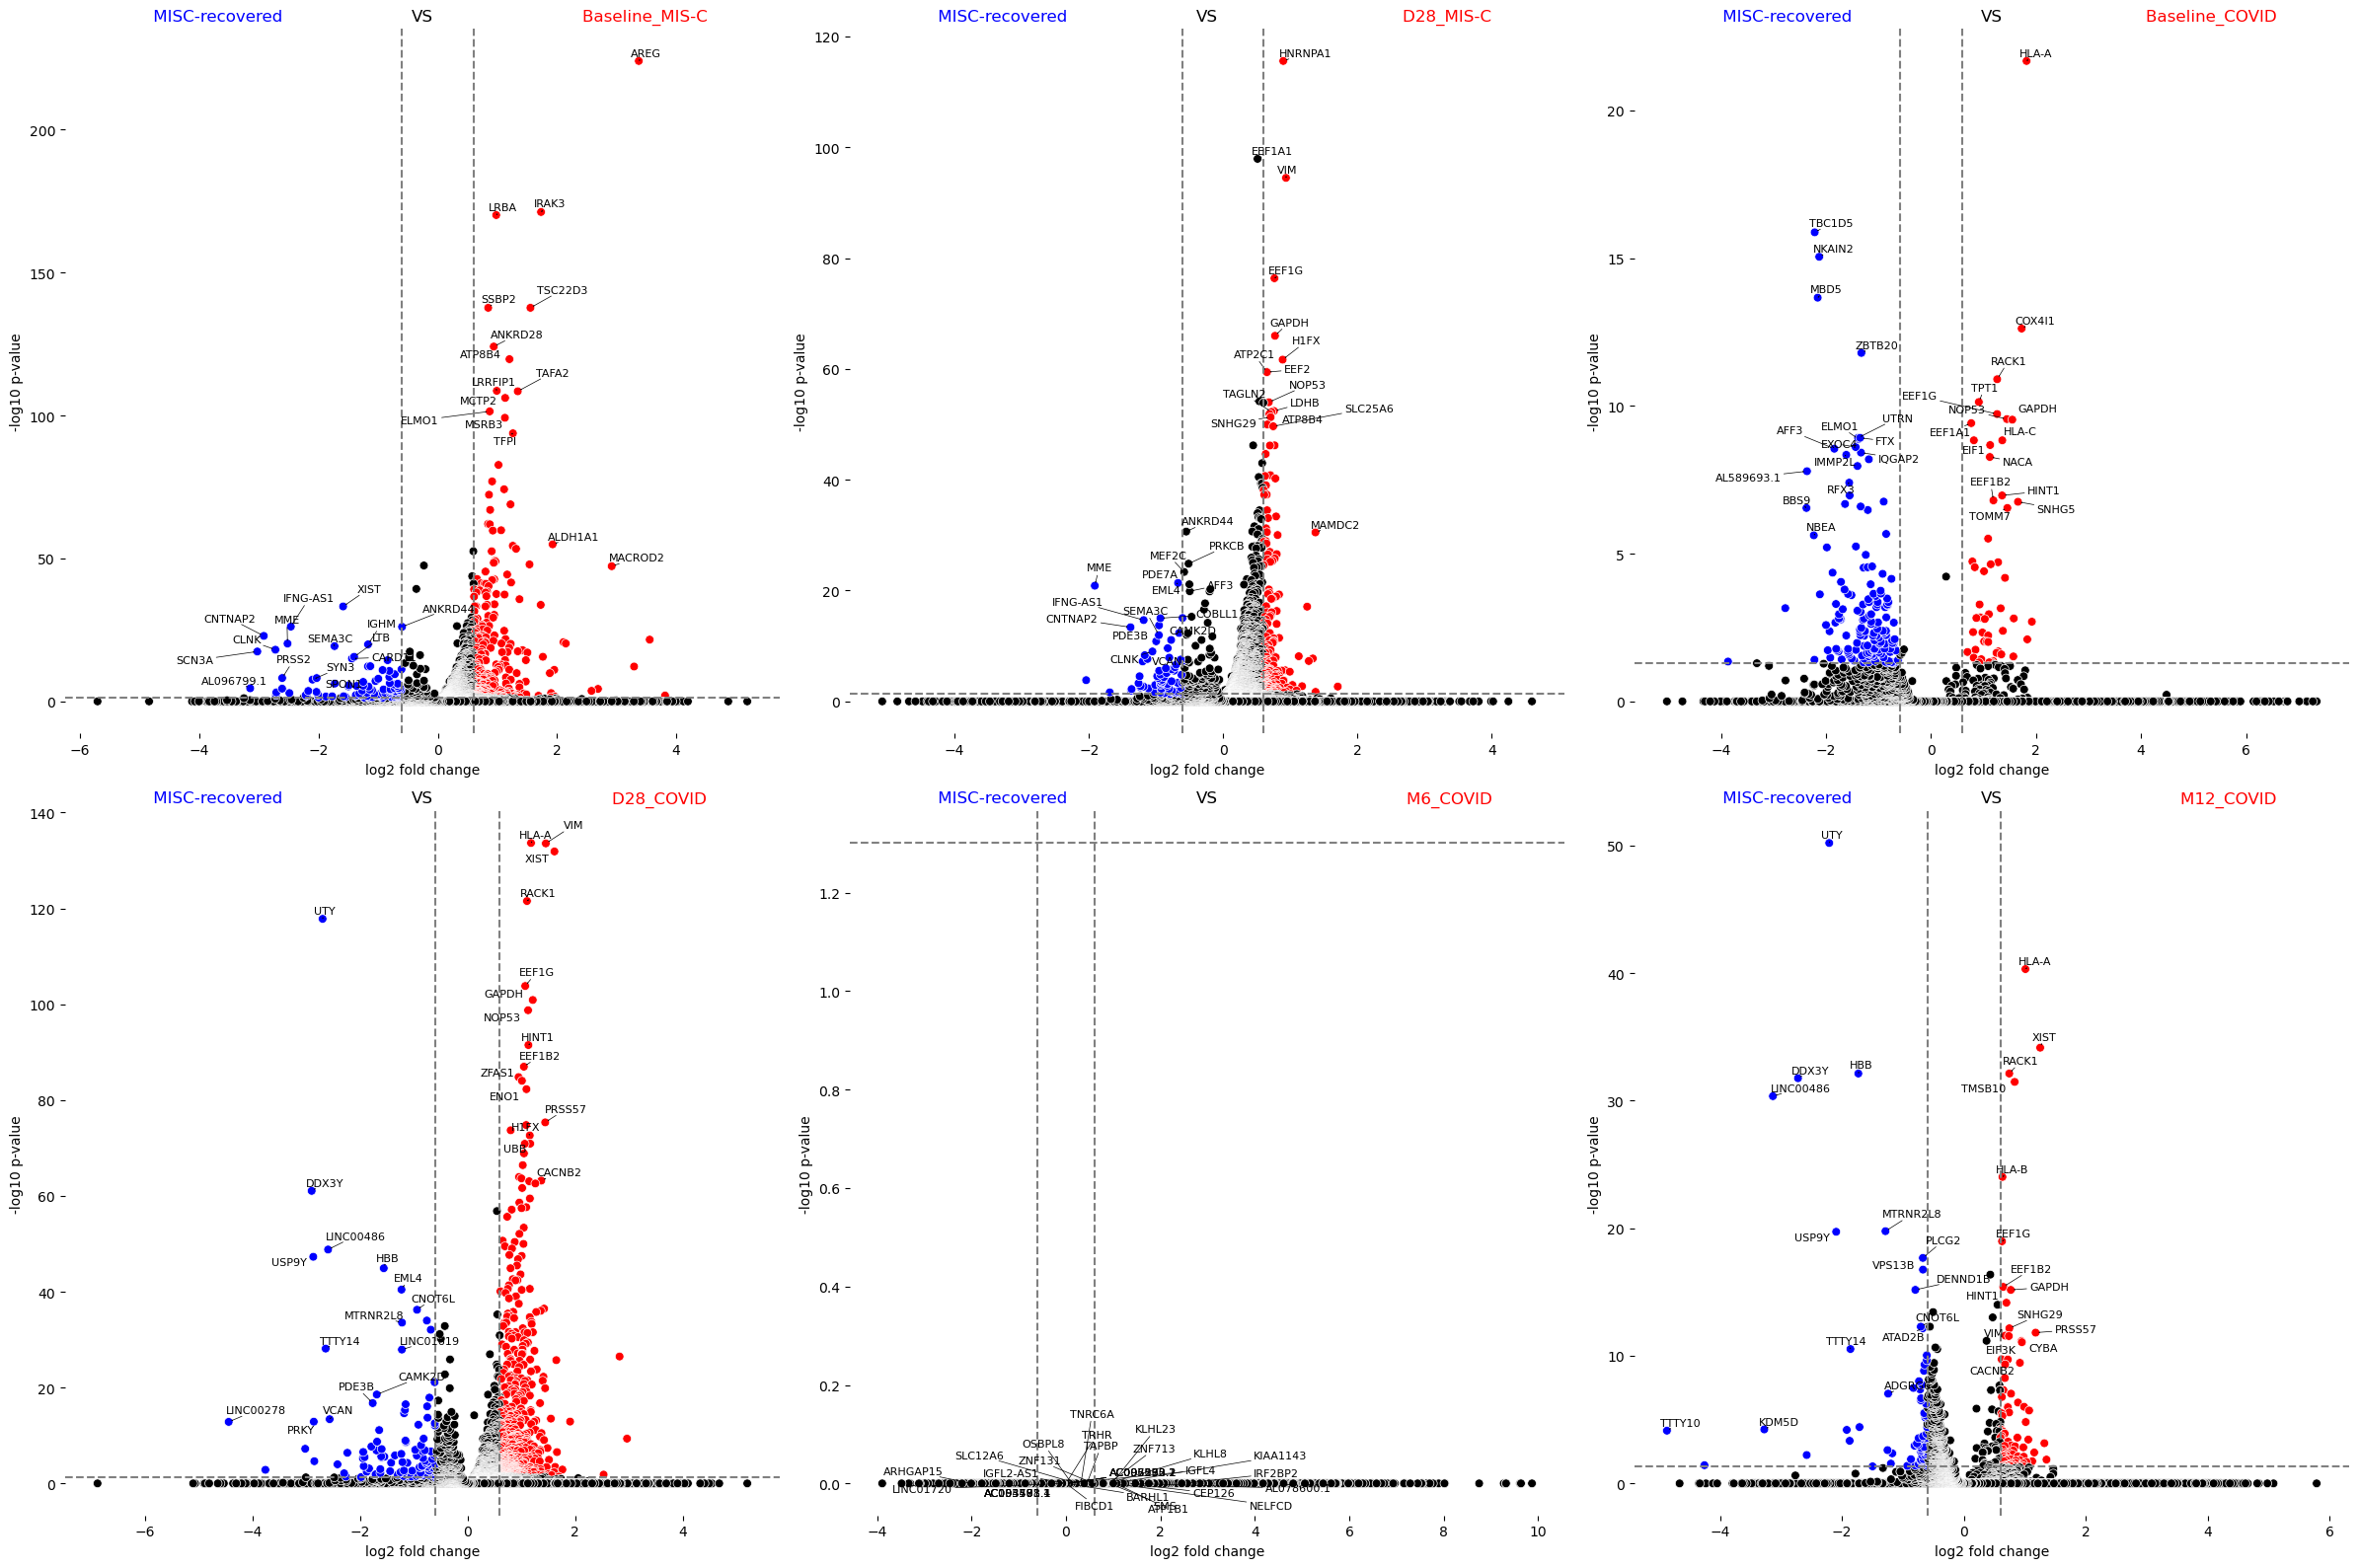

In [42]:
# Its saves the image as well
plot_data(dge_df,DGE_comparison,nrows,ncols,output_dir,out_name='hspc_MISC-recovered_all_cohorts_plots.png')

# 3. Perform DGE between 2 groups

In [23]:
rna_ad.uns['log1p'] = {'base': None}

In [43]:
condition = 'Disease.Status3'
reference = 'D28_COVID'
groups = ['Baseline_MIS-C'] # must be a list

In [44]:
# Recovered VS ALL
sc.tl.rank_genes_groups(rna_ad,groupby=condition,groups=groups,reference=reference,
                        method='wilcoxon',corr_method='benjamini-hochberg',layer='log')

## 3.1. Generate CSV file with results

In [45]:
# Extracting results from differential expression analysis
result = rna_ad.uns['rank_genes_groups']

# Convert results to DataFrame for easier manipulation
group = result['names'].dtype.names[0]
dge_data = {}
dge_data = pd.DataFrame({
        'names': result['names'][group],
        'logfoldchanges': result['logfoldchanges'][group],
        'pvals': result['pvals'][group],
        'pvals_adj': result['pvals_adj'][group],
        'scores': result['scores'][group]
    })
dge_data.to_csv(os.path.join(output_dir,f'hspc_{reference}_VS_{group}_wilcoxon.csv'))
dge_data

,names,logfoldchanges,pvals,pvals_adj,scores
0,UTY,3.392180,1.137400e-297,1.559603e-293,36.875599
1,LINC00486,3.402244,4.634324e-194,3.177292e-190,29.716978
2,DDX3Y,3.525666,3.150013e-173,1.439766e-169,28.058456
3,HBB,2.131066,1.592432e-171,6.238695e-168,27.918468
4,MAN2A1,1.424803,2.765606e-141,9.480497e-138,25.305685
...,...,...,...,...,...
27419,HLA-B,-0.883529,7.360224e-113,1.552668e-109,-22.576597
27420,B2M,-0.774731,2.287431e-134,6.970058e-131,-24.669252
27421,H3F3A,-1.098373,1.011684e-176,5.548885e-173,-28.343321
27422,HLA-A,-1.589808,2.021832e-242,1.848224e-238,-33.250290


# 3.2. Generate volcano plots for groups of interest

In [46]:
DGE_comparison = { 1: {'reference': 'D28_COVID', 'group': 'Baseline_MIS-C'}}
nrows = 1
ncols = 1

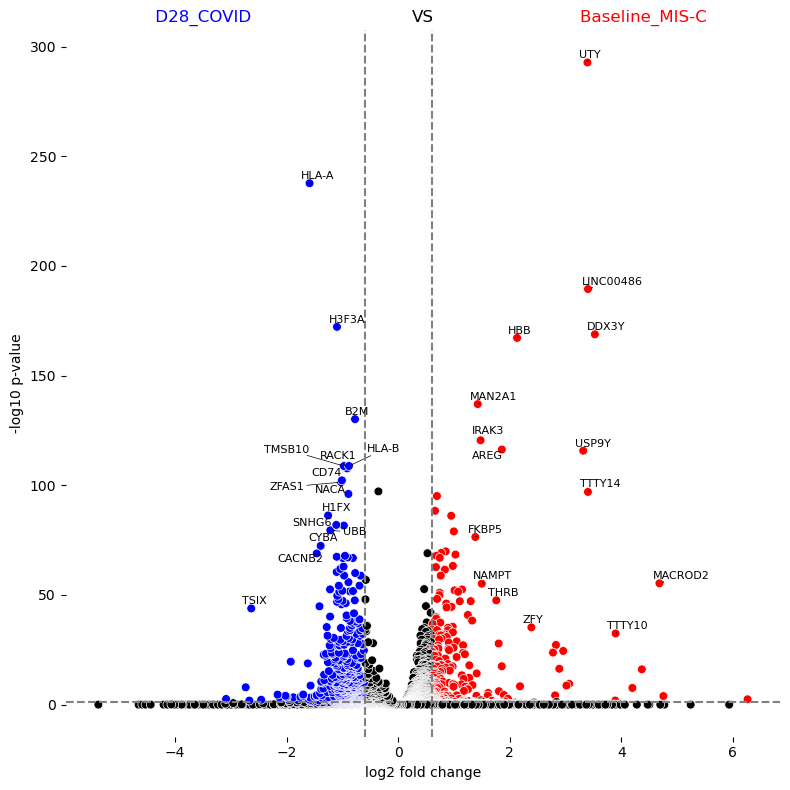

In [47]:
plot_data(dge_data,DGE_comparison,nrows,ncols,output_dir,out_name='hspc_MISC-D28_VS_Baseline_plots.png')

## 3.3 Save marker genes

Here, we are choosing marker genes with `pvals_adj` < 0.05 (use 0.01 for a strict cut off).

Then genes are ranked based on the product of `-log10(pvals_adj)` and `logfoldchanges` to get most significant and differentially expresed genes


In [57]:
# read the csv file or use the dataframe in the notebook
df = dge_data.copy()
#df = pd.read_csv(os.path.join(output_dir,'hspc_MISC-recovered_VS_D28_COVID_wilcoxon.csv'))
df

,names,logfoldchanges,pvals,pvals_adj,scores
0,UTY,3.392180,1.137400e-297,1.559603e-293,36.875599
1,LINC00486,3.402244,4.634324e-194,3.177292e-190,29.716978
2,DDX3Y,3.525666,3.150013e-173,1.439766e-169,28.058456
3,HBB,2.131066,1.592432e-171,6.238695e-168,27.918468
4,MAN2A1,1.424803,2.765606e-141,9.480497e-138,25.305685
...,...,...,...,...,...
27419,HLA-B,-0.883529,7.360224e-113,1.552668e-109,-22.576597
27420,B2M,-0.774731,2.287431e-134,6.970058e-131,-24.669252
27421,H3F3A,-1.098373,1.011684e-176,5.548885e-173,-28.343321
27422,HLA-A,-1.589808,2.021832e-242,1.848224e-238,-33.250290


In [65]:
df = df[(df['pvals_adj'] < 0.05)] # Select your cut off
df.loc[df['logfoldchanges'] > 0, 'DGE'] = 'UP'
df.loc[df['logfoldchanges'] < 0, 'DGE'] = 'DOWN'
df['-log10(pvals_adj)'] = -np.log10(df['pvals_adj'].replace(0, np.nan))  # Handle zeros
df = df.replace([np.inf, -np.inf], np.nan).dropna()
# Take a product of significance and abundance to rank the genes
df['DGE_score'] = df['-log10(pvals_adj)'] * df['logfoldchanges']
marker_genes = df.sort_values(by='DGE_score', ascending=False)
marker_genes.to_csv(os.path.join(output_dir,f'hspc_wilcoxon_markergenes.csv'))
marker_genes

,names,logfoldchanges,pvals,pvals_adj,scores,DGE,-log10(pvals_adj),DGE_score
0,UTY,3.392180,1.137400e-297,1.559603e-293,36.875599,UP,292.806986,993.254062
1,LINC00486,3.402244,4.634324e-194,3.177292e-190,29.716978,UP,189.497943,644.718301
2,DDX3Y,3.525666,3.150013e-173,1.439766e-169,28.058456,UP,168.841708,595.279550
7,USP9Y,3.316466,7.155347e-120,1.635235e-116,23.279482,UP,115.786420,384.001708
3,HBB,2.131066,1.592432e-171,6.238695e-168,27.918468,UP,167.204906,356.324705
...,...,...,...,...,...,...,...,...
27418,TMSB10,-0.973419,8.534666e-113,1.671819e-109,-22.570051,DOWN,108.776811,-105.885448
27412,H1FX,-1.257017,4.729806e-90,5.639574e-87,-20.122063,DOWN,86.248754,-108.416110
27377,TSIX,-2.635481,4.588737e-47,1.446454e-44,-14.408298,DOWN,43.839695,-115.538668
27421,H3F3A,-1.098373,1.011684e-176,5.548885e-173,-28.343321,DOWN,172.255794,-189.201103
